In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np

# csv dosyalarını yukledim
train_data = pd.read_csv(r'C:\Users\Zeynep\Downloads\cure_the_princess_train.csv')
valid_data = pd.read_csv(r'C:\Users\Zeynep\Downloads\cure_the_princess_validation.csv')
test_data = pd.read_csv(r'C:\Users\Zeynep\Downloads\cure_the_princess_test.csv')

# input size'ı train datadaki sutuna göre (oznitelik) belirledim
input_size = len(train_data.columns) - 1 

In [20]:
class CustomDataset(Dataset):
    def __init__(self, data):
        self.X = data.iloc[:, :-1].values
        self.y = data.iloc[:, -1].values.reshape(-1, 1)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return torch.tensor(self.X[index], dtype=torch.float), torch.tensor(self.y[index], dtype=torch.float)
        
train_dataset = CustomDataset(train_data)
valid_dataset = CustomDataset(valid_data)
test_dataset = CustomDataset(test_data)

# DataLoader ve batchsize
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [21]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super().__init__()
        self.hidden_layer1 = nn.Linear(input_size, hidden_size1)
        self.hidden_layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.output_layer = nn.Linear(hidden_size2, output_size)
        # relu ve sigmoid aktivasyon fonksiyonları
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden_layer1(x))
        x = self.relu(self.hidden_layer2(x))
        x = self.sigmoid(self.output_layer(x))
        return x
output_size = len(np.unique(train_data.iloc[:, -1].values))

In [22]:
model = MLP(input_size=input_size, hidden_size1=100, hidden_size2=50, output_size=output_size)
# 1. hidden size kısmında 100, 2. hidden size kısmında 50 nöron bulunan neural network'u'tanımladım

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Random seed'i ilk olarak 1 ayarladim. kodumu 1 defa çalistirdiktan sonra oğrenci numaram olan 190401025 ile degiştirdim.
torch.manual_seed(190401025)

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# grafik icin gerekli listeler olusturuldu
train_losses = []
valid_losses = []

# optimizer ve loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# train
def train(model, dataloader, criterion, optimizer):
    train_loss = 0
    train_acc = 0
    total = 0
    
    model.train()
    
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets.squeeze().long())
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        train_acc += (predicted == targets.squeeze().long()).sum().item()
        train_loss += loss.item() * inputs.size(0)
        
    return train_loss / total, train_acc / total

# evaluate
def evaluate(model, dataloader, criterion):
    valid_loss = 0
    valid_acc = 0
    total = 0
    
    model.eval()
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze().long())
            
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            valid_acc += (predicted == targets.squeeze().long()).sum().item()
            valid_loss += loss.item() * inputs.size(0)
        
    return valid_loss / total, valid_acc / total

# early stopping
patience = 5
early_stopping_counter = 0
best_valid_loss = np.inf
best_model_state_dict = None

# egitim
n_epochs = 50

for epoch in range(n_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
    
    # listeye ekleniyor
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_model_state_dict = model.state_dict()
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    
    if early_stopping_counter >= patience:
        print(f'Validation loss did not improve for {patience} epochs. Stopping early...')
        break
    
    print(f'Epoch: {epoch}  Train Loss: {train_loss:.4f}  Train Acc: %{train_acc*100:.2f}  Valid Loss: {valid_loss:.4f}  Valid Acc: %{valid_acc*100:.2f}')
    
torch.save(best_model_state_dict, 'chechpoint.pt')

Epoch: 0  Train Loss: 0.6550  Train Acc: %64.22  Valid Loss: 0.5984  Valid Acc: %73.25
Epoch: 1  Train Loss: 0.5710  Train Acc: %78.19  Valid Loss: 0.5262  Valid Acc: %82.80
Epoch: 2  Train Loss: 0.5192  Train Acc: %81.95  Valid Loss: 0.4816  Valid Acc: %85.99
Epoch: 3  Train Loss: 0.4902  Train Acc: %84.58  Valid Loss: 0.4504  Valid Acc: %90.45
Epoch: 4  Train Loss: 0.4752  Train Acc: %85.78  Valid Loss: 0.4827  Valid Acc: %83.44
Epoch: 5  Train Loss: 0.4639  Train Acc: %85.54  Valid Loss: 0.4523  Valid Acc: %86.62
Epoch: 6  Train Loss: 0.4556  Train Acc: %86.50  Valid Loss: 0.4239  Valid Acc: %91.72
Epoch: 7  Train Loss: 0.4482  Train Acc: %87.62  Valid Loss: 0.4177  Valid Acc: %91.72
Epoch: 8  Train Loss: 0.4423  Train Acc: %88.26  Valid Loss: 0.4090  Valid Acc: %92.04
Epoch: 9  Train Loss: 0.4364  Train Acc: %88.10  Valid Loss: 0.4102  Valid Acc: %91.08
Epoch: 10  Train Loss: 0.4350  Train Acc: %88.26  Valid Loss: 0.4090  Valid Acc: %92.36
Epoch: 11  Train Loss: 0.4304  Train Acc: 

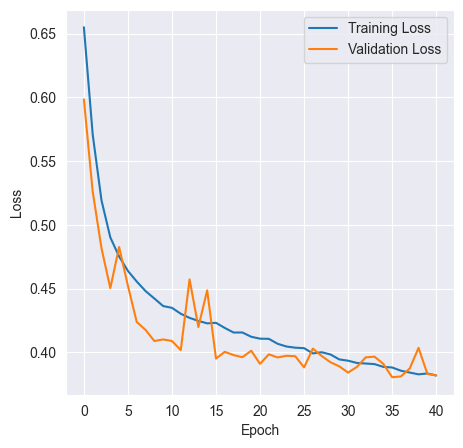

In [25]:
# grafik
sns.set_style('darkgrid')
plt.figure(figsize=(5,5))
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
model.load_state_dict(torch.load('checkpoint.pt'))

# test
def test(model, dataloader, criterion):
    test_loss = 0
    test_acc = 0
    total = 0
    
    model.eval()
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            loss = criterion(outputs, targets.squeeze().long())
            
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            test_acc += (predicted == targets.squeeze().long()).sum().item()
            test_loss += loss.item() * inputs.size(0)
        
    return test_loss / total, test_acc / total
   
# test veri seti üzerinde model performansı
test_loss, test_acc = test(model, test_loader, criterion)

print('Test Loss: ' ,test_loss , 'Test Acc: %', test_acc*100)


Test Loss:  0.36001139446861385 Test Acc: % 95.46632124352331


In [27]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
y_true = []
y_pred = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        predicted = torch.argmax(outputs, dim=1)
        y_true += labels.cpu().tolist()
        y_pred += predicted.cpu().tolist()

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')

print('Accuracy:', accuracy)
print('F1 score:', f1)
print('Precision:', precision)
print('Recall:', recall)

Accuracy: 0.9546632124352331
F1 score: 0.9546412174015226
Precision: 0.9558953140242877
Recall: 0.9548029424398625
